In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hate-speech-and-offensive-language-detection/train.csv


# Importing Libraries

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import string

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('all')

from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator

from collections import Counter

from matplotlib import ticker
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report


sns.set(style="darkgrid")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.z

# Data Exploration  

In [3]:
data=pd.read_csv('/kaggle/input/hate-speech-and-offensive-language-detection/train.csv')
data.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
data['class'].value_counts()

class
1    19190
2     4163
0     1430
Name: count, dtype: int64

Here,
0 - hate speech
1 - offensive language
2 - neither

In [5]:
data.describe()

,count,hate_speech_count,offensive_language_count,neither_count,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247,1.110277
std,0.883060,0.631851,1.399459,1.113299,0.462089
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000,1.000000
50%,3.000000,0.000000,3.000000,0.000000,1.000000
75%,3.000000,0.000000,3.000000,0.000000,1.000000
max,9.000000,7.000000,9.000000,9.000000,2.000000


In [6]:
data.isna().sum()

count                       0
hate_speech_count           0
offensive_language_count    0
neither_count               0
class                       0
tweet                       0
dtype: int64

There are no null values in the dataset

In [7]:
data.duplicated().sum()

0

There are no duplicate values in the dataset

Therefore there is no requirement for data cleaning

In [8]:
fdata=data[['tweet','class']]
fdata.head()

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


### Data Visualization - Distribution of tweet counts per classification category

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='class', ylabel='Count'>

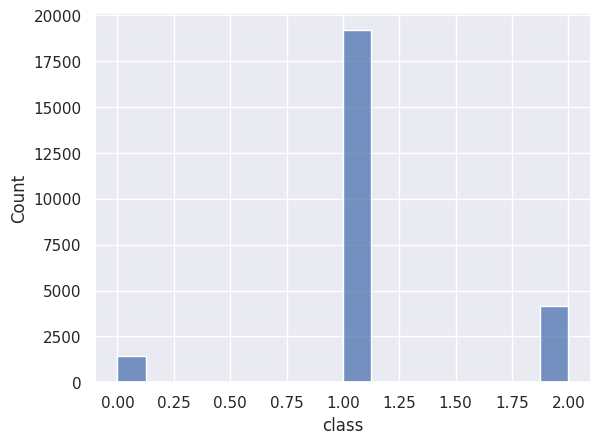

In [9]:
sns.histplot(data['class'])

# Data Processing

To remove the links from text attribute, we have defined the following function with the help of 'Regex'.

### URL Removal

In [10]:
# URL Removal
fdata["tweet"] = fdata["tweet"].apply(lambda x:re.sub(r'https?://\S+', '', str(x)))
fdata["tweet"]

/tmp/ipykernel_27/3251741326.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdata["tweet"] = fdata["tweet"].apply(lambda x:re.sub(r'https?://\S+', '', str(x)))


0        !!! RT @mayasolovely: As a woman you shouldn't...
1        !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2        !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3        !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4        !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
                               ...                        
24778    you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779    you've gone and broke the wrong heart baby, an...
24780    young buck wanna eat!!.. dat nigguh like I ain...
24781                youu got wild bitches tellin you lies
24782    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object

### Lowercase Removal

In [11]:
# Lowercase removal
fdata['tweet'] = fdata['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
fdata['tweet']

/tmp/ipykernel_27/751160132.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdata['tweet'] = fdata['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))


0        !!! rt @mayasolovely: as a woman you shouldn't...
1        !!!!! rt @mleew17: boy dats cold...tyga dwn ba...
2        !!!!!!! rt @urkindofbrand dawg!!!! rt @80sbaby...
3        !!!!!!!!! rt @c_g_anderson: @viva_based she lo...
4        !!!!!!!!!!!!! rt @shenikaroberts: the shit you...
                               ...                        
24778    you's a muthaf***in lie &#8220;@lifeasking: @2...
24779    you've gone and broke the wrong heart baby, an...
24780    young buck wanna eat!!.. dat nigguh like i ain...
24781                youu got wild bitches tellin you lies
24782    ~~ruffled | ntac eileen dahlia - beautiful col...
Name: tweet, Length: 24783, dtype: object

### Punctuation Removal

In [12]:
# Punctuation Removal

fdata['tweet'] = fdata['tweet'].str.replace('[^\w\s]','')
fdata['tweet']

/tmp/ipykernel_27/3660026803.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdata['tweet'] = fdata['tweet'].str.replace('[^\w\s]','')


0        !!! rt @mayasolovely: as a woman you shouldn't...
1        !!!!! rt @mleew17: boy dats cold...tyga dwn ba...
2        !!!!!!! rt @urkindofbrand dawg!!!! rt @80sbaby...
3        !!!!!!!!! rt @c_g_anderson: @viva_based she lo...
4        !!!!!!!!!!!!! rt @shenikaroberts: the shit you...
                               ...                        
24778    you's a muthaf***in lie &#8220;@lifeasking: @2...
24779    you've gone and broke the wrong heart baby, an...
24780    young buck wanna eat!!.. dat nigguh like i ain...
24781                youu got wild bitches tellin you lies
24782    ~~ruffled | ntac eileen dahlia - beautiful col...
Name: tweet, Length: 24783, dtype: object

### Username/Handles Removal

In [13]:
# Function to remove usernames/handles

fdata["tweet"] = fdata["tweet"].apply(lambda x:re.sub(r'@\w+', '', str(x)))
fdata["tweet"]

/tmp/ipykernel_27/3397600024.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdata["tweet"] = fdata["tweet"].apply(lambda x:re.sub(r'@\w+', '', str(x)))


0        !!! rt : as a woman you shouldn't complain abo...
1        !!!!! rt : boy dats cold...tyga dwn bad for cu...
2        !!!!!!! rt  dawg!!!! rt : you ever fuck a bitc...
3                   !!!!!!!!! rt :  she look like a tranny
4        !!!!!!!!!!!!! rt : the shit you hear about me ...
                               ...                        
24778    you's a muthaf***in lie &#8220;:   right! his ...
24779    you've gone and broke the wrong heart baby, an...
24780    young buck wanna eat!!.. dat nigguh like i ain...
24781                youu got wild bitches tellin you lies
24782    ~~ruffled | ntac eileen dahlia - beautiful col...
Name: tweet, Length: 24783, dtype: object

### Emoji Removal

In [14]:
# Emoji Removal
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
fdata["tweet"] = fdata["tweet"].apply(str)
fdata["tweet"] = fdata["tweet"].apply(remove_emoji)
fdata["tweet"]

/tmp/ipykernel_27/2571909864.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdata["tweet"] = fdata["tweet"].apply(str)
/tmp/ipykernel_27/2571909864.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdata["tweet"] = fdata["tweet"].apply(remove_emoji)


0        !!! rt : as a woman you shouldn't complain abo...
1        !!!!! rt : boy dats cold...tyga dwn bad for cu...
2        !!!!!!! rt  dawg!!!! rt : you ever fuck a bitc...
3                   !!!!!!!!! rt :  she look like a tranny
4        !!!!!!!!!!!!! rt : the shit you hear about me ...
                               ...                        
24778    you's a muthaf***in lie &#8220;:   right! his ...
24779    you've gone and broke the wrong heart baby, an...
24780    young buck wanna eat!!.. dat nigguh like i ain...
24781                youu got wild bitches tellin you lies
24782    ~~ruffled | ntac eileen dahlia - beautiful col...
Name: tweet, Length: 24783, dtype: object

### Single character and double space removal

In [15]:
# Single character and double space removal
fdata["tweet"] = fdata["tweet"].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
fdata["tweet"] = fdata["tweet"].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
fdata["tweet"]

/tmp/ipykernel_27/2924179581.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdata["tweet"] = fdata["tweet"].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
/tmp/ipykernel_27/2924179581.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdata["tweet"] = fdata["tweet"].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))


0        !!! rt : aswoman you shouldn't complain about ...
1        !!!!! rt : boy dats cold...tyga dwn bad for cu...
2        !!!!!!! rt dawg!!!! rt : you ever fuckbitch an...
3                       !!!!!!!!! rt : she look liketranny
4        !!!!!!!!!!!!! rt : the shit you hear about me ...
                               ...                        
24778    you'smuthaf***in lie &#8220;: right! his tl is...
24779    you've gone and broke the wrong heart baby, an...
24780    young buck wanna eat!!.. dat nigguh likeaint f...
24781                youu got wild bitches tellin you lies
24782    ~~ruffled | ntac eileen dahlia - beautiful col...
Name: tweet, Length: 24783, dtype: object

Lets see the top 10 most common words in the dataset

In [16]:
# Most common words
from collections import Counter
cnt = Counter()
for text in fdata["tweet"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('rt', 7548),
 ('the', 7087),
 (':', 6696),
 ('you', 5387),
 ('bitch', 5325),
 ('to', 5178),
 ('and', 3626),
 ('my', 3522),
 ('that', 3261),
 ('in', 2763)]

The words 'rt' and the colon are most common and are not needed for our analysis. We will remove them

In [17]:
# Function to remove words "rt" and colons ":"
def remove_words_and_colons(text):
    words_to_remove = ["rt"]
    for word in words_to_remove:
        text = text.replace(word, "")
    text = text.replace(":", "")
    return text

# Applying the function to the 'tweet' column
fdata['tweet'] = fdata['tweet'].apply(remove_words_and_colons)

# Displaying the updated DataFrame
fdata

/tmp/ipykernel_27/1408741282.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdata['tweet'] = fdata['tweet'].apply(remove_words_and_colons)


,tweet,class
0,!!! aswoman you shouldn't complain about cle...,2
1,!!!!! boy dats cold...tyga dwn bad for cuffi...,1
2,!!!!!!! dawg!!!! you ever fuckbitch and she...,1
3,!!!!!!!!! she look liketranny,1
4,!!!!!!!!!!!!! the shit you hear about me mig...,1
...,...,...
24778,you'smuthaf***in lie &#8220; right! his tl is ...,1
24779,"you've gone and broke the wrong hea baby, and ...",2
24780,young buck wanna eat!!.. dat nigguh likeaint f...,1
24781,youu got wild bitches tellin you lies,1


There are a lot of numeric and special characters in our tweets. We will go ahead and remove them

In [18]:
# Lambda function to remove special and numeric characters
remove_special_and_numeric = lambda text: re.sub(r"[^a-zA-Z\s]+", "", text)

# Apply the function to the 'tweets' column using lambda
fdata['tweet'] = fdata['tweet'].apply(remove_special_and_numeric)

fdata.head()

/tmp/ipykernel_27/3449479404.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdata['tweet'] = fdata['tweet'].apply(remove_special_and_numeric)


,tweet,class
0,aswoman you shouldnt complain about cleanin...,2
1,boy dats coldtyga dwn bad for cuffin dat ho...,1
2,dawg you ever fuckbitch and she sta to cry...,1
3,she look liketranny,1
4,the shit you hear about me might be true or...,1


### Stopword Removal

In [19]:
# Stopword Removal
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

fdata["Text_stop"] = fdata["tweet"].apply(lambda text: remove_stopwords(text))
fdata

/tmp/ipykernel_27/3438731790.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdata["Text_stop"] = fdata["tweet"].apply(lambda text: remove_stopwords(text))


,tweet,class,Text_stop
0,aswoman you shouldnt complain about cleanin...,2,aswoman shouldnt complain cleaning house amp a...
1,boy dats coldtyga dwn bad for cuffin dat ho...,1,boy dats coldtyga dwn bad cuffin dat hoe st place
2,dawg you ever fuckbitch and she sta to cry...,1,dawg ever fuckbitch sta cry confused shit
3,she look liketranny,1,look liketranny
4,the shit you hear about me might be true or...,1,shit hear might true might faker bitch told ya
...,...,...,...
24778,yousmuthafin lie right his tl is trash now m...,1,yousmuthafin lie right tl trash mine bible scr...
24779,youve gone and broke the wrong hea baby and dr...,2,youve gone broke wrong hea baby drove redneck ...
24780,young buck wanna eat dat nigguh likeaint fucki...,1,young buck wanna eat dat nigguh likeaint fucki...
24781,youu got wild bitches tellin you lies,1,youu got wild bitches tellin lies


# Feature Engineering

## Tokenization of data

In [20]:
import textblob           
from textblob import TextBlob

def tokenization(text):
    text = re.split('\W+', text)
    return text

fdata['Text_tokenized'] = fdata['Text_stop'].apply(lambda x: tokenization(x.lower()))
fdata.head()

/tmp/ipykernel_27/686745706.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdata['Text_tokenized'] = fdata['Text_stop'].apply(lambda x: tokenization(x.lower()))


,tweet,class,Text_stop,Text_tokenized
0,aswoman you shouldnt complain about cleanin...,2,aswoman shouldnt complain cleaning house amp a...,"[aswoman, shouldnt, complain, cleaning, house,..."
1,boy dats coldtyga dwn bad for cuffin dat ho...,1,boy dats coldtyga dwn bad cuffin dat hoe st place,"[boy, dats, coldtyga, dwn, bad, cuffin, dat, h..."
2,dawg you ever fuckbitch and she sta to cry...,1,dawg ever fuckbitch sta cry confused shit,"[dawg, ever, fuckbitch, sta, cry, confused, shit]"
3,she look liketranny,1,look liketranny,"[look, liketranny]"
4,the shit you hear about me might be true or...,1,shit hear might true might faker bitch told ya,"[shit, hear, might, true, might, faker, bitch,..."


### Lemmitization of Data

In [21]:
! python3 -m nltk.downloader wordnet
! unzip /root/nltk_data/corpora/wordnet.zip -d /root/nltk_data/corpora/
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
unzip:  cannot find or open /root/nltk_data/corpora/wordnet.zip, /root/nltk_data/corpora/wordnet.zip.zip or /root/nltk_data/corpora/wordnet.zip.ZIP.
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: 

In [22]:
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer
wordNet = WordNetLemmatizer()
def lemmatizer(text):
    text = [wordNet.lemmatize(word) for word in text]
    return text

fdata['Text_lemmatized'] = fdata['Text_tokenized'].apply(lambda x: lemmatizer(x))
fdata.head()

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


/tmp/ipykernel_27/4075825113.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdata['Text_lemmatized'] = fdata['Text_tokenized'].apply(lambda x: lemmatizer(x))


,tweet,class,Text_stop,Text_tokenized,Text_lemmatized
0,aswoman you shouldnt complain about cleanin...,2,aswoman shouldnt complain cleaning house amp a...,"[aswoman, shouldnt, complain, cleaning, house,...","[aswoman, shouldnt, complain, cleaning, house,..."
1,boy dats coldtyga dwn bad for cuffin dat ho...,1,boy dats coldtyga dwn bad cuffin dat hoe st place,"[boy, dats, coldtyga, dwn, bad, cuffin, dat, h...","[boy, dat, coldtyga, dwn, bad, cuffin, dat, ho..."
2,dawg you ever fuckbitch and she sta to cry...,1,dawg ever fuckbitch sta cry confused shit,"[dawg, ever, fuckbitch, sta, cry, confused, shit]","[dawg, ever, fuckbitch, sta, cry, confused, shit]"
3,she look liketranny,1,look liketranny,"[look, liketranny]","[look, liketranny]"
4,the shit you hear about me might be true or...,1,shit hear might true might faker bitch told ya,"[shit, hear, might, true, might, faker, bitch,...","[shit, hear, might, true, might, faker, bitch,..."


# Data Modeling

In [23]:
X = fdata["Text_stop"]
y = fdata["class"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20)

### Performing TF-IDF Conversion

In [24]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit((X_train).values.astype('U'))
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  124529


In [25]:
X_train = vectoriser.transform((X_train).values.astype('U'))
X_test  = vectoriser.transform((X_test).values.astype('U'))

# Model Evaluation

In [26]:
def model_evaluate(model,X_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    cm_df = pd.DataFrame(cm,
                     index = ['hate speech','offensive language','Neutral'], 
                     columns = ['hate speech','offensive language','Neutral'])

    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, cmap="Oranges",linecolor="gray")
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

## Logistic Regression Model

In [27]:
lr_model = LogisticRegression(C = 1, max_iter = 1000, penalty = 'l2', n_jobs=-1)
lr_model.fit(X_train  ,y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


LogisticRegression(C=1, max_iter=1000, n_jobs=-1)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

              precision    recall  f1-score   support

           0       0.57      0.15      0.24       297
           1       0.88      0.97      0.92      3829
           2       0.84      0.64      0.73       831

    accuracy                           0.87      4957
   macro avg       0.76      0.59      0.63      4957
weighted avg       0.85      0.87      0.85      4957



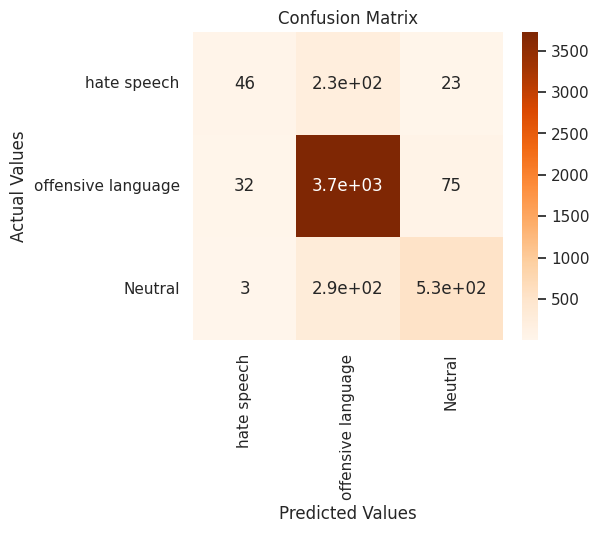

In [28]:
model_evaluate(lr_model ,X_test)

## Decision Tree Model

In [29]:
from sklearn.tree import DecisionTreeClassifier 

dtmodel = DecisionTreeClassifier()
dtc = dtmodel.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

              precision    recall  f1-score   support

           0       0.34      0.27      0.30       297
           1       0.91      0.92      0.91      3829
           2       0.76      0.75      0.76       831

    accuracy                           0.86      4957
   macro avg       0.67      0.65      0.66      4957
weighted avg       0.85      0.86      0.85      4957



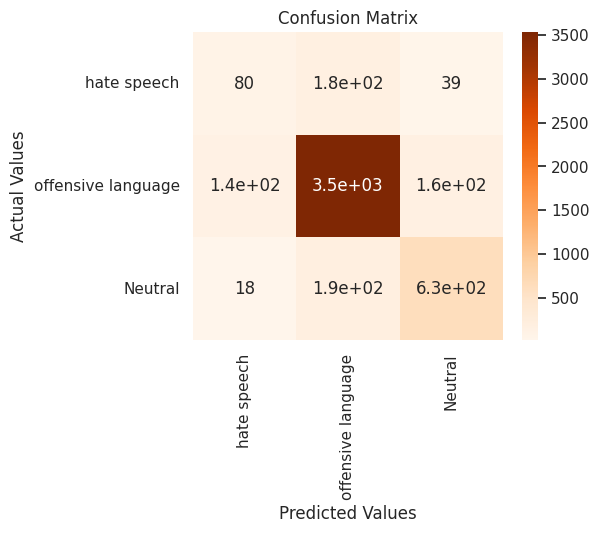

In [30]:
model_evaluate(dtc ,X_test)

## K-Neighbors Classifier

In [31]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train  ,y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


KNeighborsClassifier(n_neighbors=3)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

              precision    recall  f1-score   support

           0       0.37      0.25      0.30       297
           1       0.84      0.96      0.90      3829
           2       0.77      0.38      0.51       831

    accuracy                           0.82      4957
   macro avg       0.66      0.53      0.57      4957
weighted avg       0.80      0.82      0.79      4957



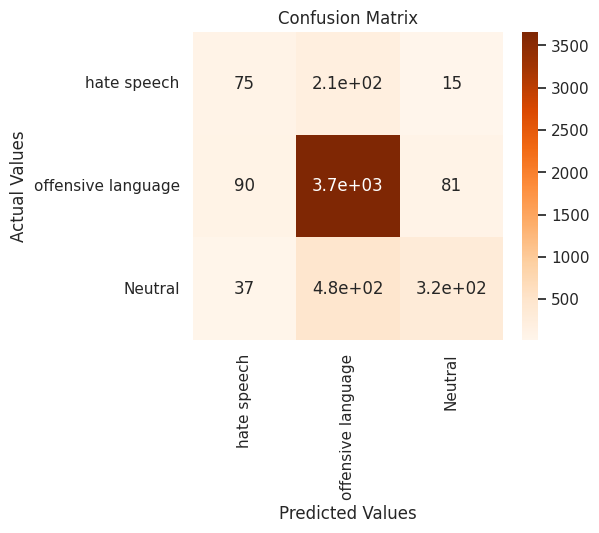

In [32]:
model_evaluate(neigh ,X_test)

## Random Forest Classifier

In [33]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
rfc=RandomForestClassifier(n_estimators=10)

#Train the model using the training sets y_pred=clf.predict(X_test)
rfc.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


RandomForestClassifier(n_estimators=10)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

              precision    recall  f1-score   support

           0       0.56      0.21      0.30       297
           1       0.88      0.97      0.92      3829
           2       0.84      0.63      0.72       831

    accuracy                           0.87      4957
   macro avg       0.76      0.60      0.65      4957
weighted avg       0.85      0.87      0.85      4957



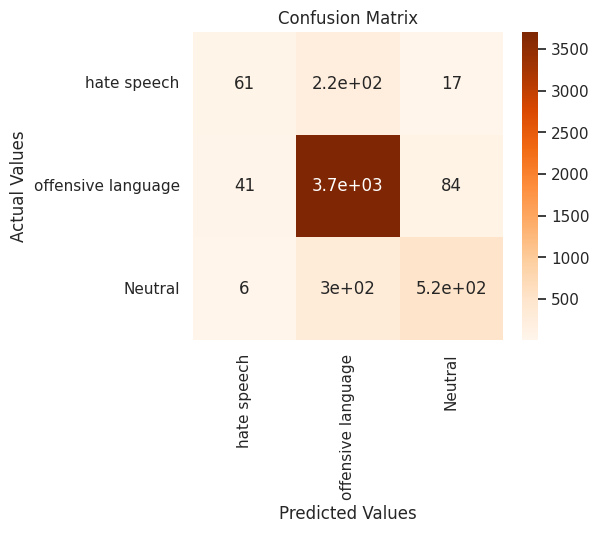

In [34]:
model_evaluate(rfc ,X_test)

In [35]:
#Import XGB FModel
import xgboost as xgb

#Create a XGB Classifier
xgb_model=xgb.XGBClassifier(objective="multi:softprob")

#Train the model using the training sets
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

              precision    recall  f1-score   support

           0       0.54      0.18      0.26       297
           1       0.88      0.97      0.92      3829
           2       0.86      0.64      0.73       831

    accuracy                           0.87      4957
   macro avg       0.76      0.59      0.64      4957
weighted avg       0.85      0.87      0.85      4957



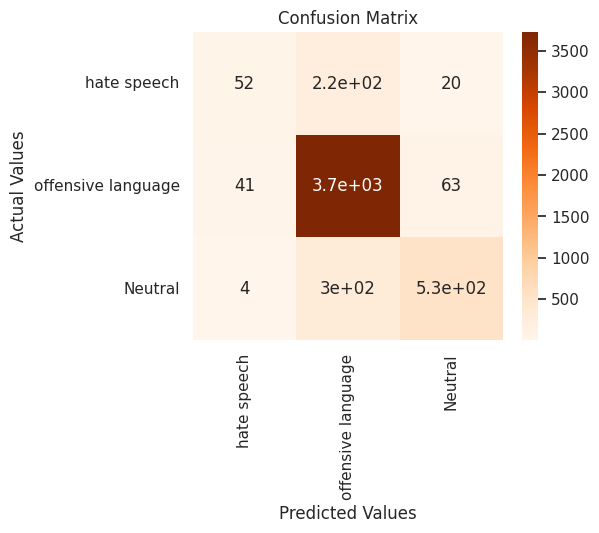

In [36]:
model_evaluate(xgb_model,X_test)

## LGBM Classifier

In [37]:
import lightgbm as lgb
lgb = lgb.LGBMClassifier()
lgb.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check

LGBMClassifier()

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

              precision    recall  f1-score   support

           0       0.51      0.21      0.30       297
           1       0.88      0.96      0.92      3829
           2       0.83      0.64      0.72       831

    accuracy                           0.86      4957
   macro avg       0.74      0.60      0.65      4957
weighted avg       0.85      0.86      0.85      4957



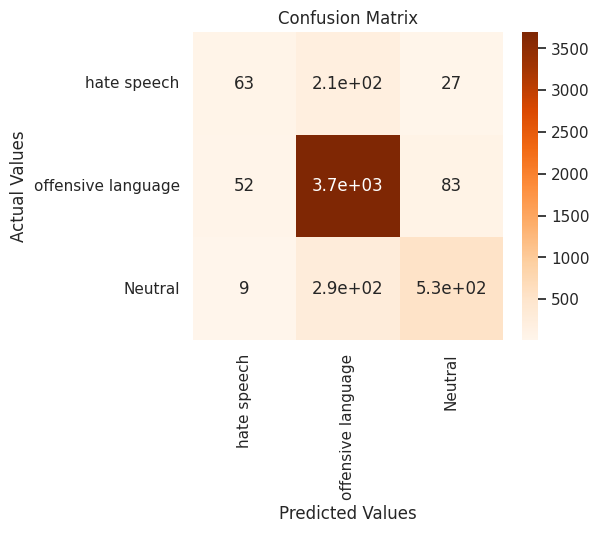

In [38]:
model_evaluate(lgb,X_test)

The Logistic Regression,XGB Classifier and LGBM Classifer perform better than the other models. We will select the LGBM Model and perform Hyperparameter to try to improve the metrics for our model

# Hyperparameter Tuning

In [39]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

# Define the LightGBM model
model = lgb.LGBMClassifier()

# Define hyperparameters for tuning
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   n_iter=8, scoring='accuracy', cv=3, random_state=42)

In [40]:
# Fit the model
random_search.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(), n_iter=8,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200]},
                   random_state=42, scoring='accuracy')

In [41]:
# Print the best parameters and the best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}
Best Score: 0.8633609062824424


In [42]:
# Evaluate the model with best parameters on the test set
best_model = random_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test Score:", test_score)

Test Score: 0.8561630018156143


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

              precision    recall  f1-score   support

           0       0.49      0.16      0.25       297
           1       0.86      0.97      0.92      3829
           2       0.86      0.57      0.68       831

    accuracy                           0.86      4957
   macro avg       0.74      0.57      0.61      4957
weighted avg       0.84      0.86      0.84      4957



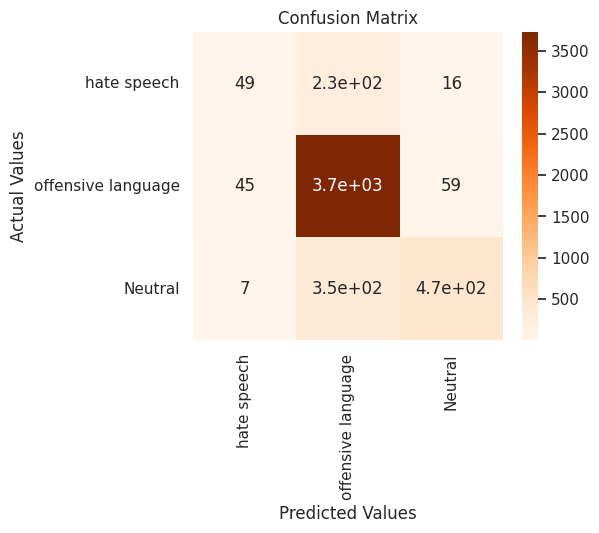

In [43]:
model_evaluate(best_model,X_test)